 Exploration of Neural Network libraries in Python: Training a Feedforward Neural Network for Regression

In [1]:
import sys, os
sys.path.append(os.path.join(os.getcwd().split('ICM')[0], 'ICM', 'code'))
import ICM_utils

/Users/paul.pop/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
import pandas as pd
pd.options.mode.chained_assignment = None

import numpy as np
import matplotlib.pyplot as plt

from sklearn import linear_model
from sklearn.ensemble import VotingClassifier
from sklearn.cross_validation import KFold, cross_val_score
from sklearn.svm import LinearSVC, SVC
from sklearn.datasets import make_classification
# from sklearn.preprocessing import LabelEncoder
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from keras import metrics
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Activation, Dense, BatchNormalization, Dropout
from keras import optimizers
from keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier
from keras.utils.np_utils import to_categorical

%matplotlib inline 
import time, math

/Users/paul.pop/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
IMC_basedir = os.getcwd().split('code')[0]
DATA_AMELIA_FILE = os.path.join(IMC_basedir, 'data/imputed_dataset_no_censoring_26022018_Amelia1.csv')
DATA_MICE_FILE = os.path.join(IMC_basedir, 'data/imputed_dataset_no_censoring_26022018_MICE.csv')
TRAIN_FILE = os.path.join(IMC_basedir, 'data/amelia_train')
TEST_FILE = os.path.join(IMC_basedir, 'data/amelia_test')
MODEL_DIR = os.path.join(IMC_basedir, 'data/amelia_model')

In [13]:
df, labels = ICM_utils.process_amelia(DATA_AMELIA_FILE)

In [17]:
life = df['life_expectancy']

In [19]:
life = life.sort_values()

In [38]:
df.columns

Index(['Gender', 'Tumor_grade', 'Age_surgery', 'life_expectancy', 'IDH_TERT',
       'IK', 'life_expectancy_bin', 'Tumor_Location_A', 'Tumor_Location_B',
       'Tumor_Location_C', 'Tumor_Location_N', 'Tumor_Location_autre',
       'Gene_Mdm2_AMPLIFIE', 'Gene_Mdm2_NORMAL', 'TERT_mutant', 'TERT_wt',
       'Surgery_type_aucune', 'Surgery_type_biopsie', 'Surgery_type_exérèse',
       'Surgery_type_partielle', 'Gene_Cdk4_AMPLIFIE', 'Gene_Cdk4_NORMAL',
       'Gene_Ch10Q_NON PERTE', 'Gene_Ch10Q_PERTE', 'X1p19q_codel_0',
       'X1p19q_codel_1', 'Gene_P16_DELETE', 'Gene_P16_NORMAL',
       'Gene_Ihc_Atrx_Extinction diffuse', 'Gene_Ihc_Atrx_Maintien',
       'Gene_Ihc_Atrx_extinction', 'IDH_NC', 'IDH_mutant', 'IDH_wt',
       'Tumor_type_GBM', 'Tumor_type_astrocytome',
       'Tumor_type_astrocytome gémistocytique (=A2)',
       'Tumor_type_astrocytome pilocytique', 'Tumor_type_gangliogliome',
       'Tumor_type_gliome', 'Tumor_type_oligo', 'Tumor_Position_D',
       'Tumor_Position_G', 'Tum

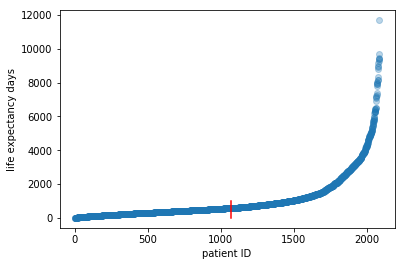

In [36]:
plt.scatter(range(len(life)),life, alpha=0.3)
plt.xlabel('patient ID')
plt.ylabel('life expectancy days')
plt.plot([life.mean(), life.mean()], [0,1000], color='r')

In [5]:
X_train_r, Y_train_r, X_test_r, Y_test_r = ICM_utils.get_train_test_data(df, regression=True, train_size=0.8)
X_train_c, Y_train_c, X_test_c, Y_test_c = ICM_utils.get_train_test_data(df, regression=False, train_size=0.8)

# Benchmark Logistic Regression (Scikit-learn)

             precision    recall  f1-score   support

    6months       0.25      0.18      0.21        76
    1.2year       0.36      0.58      0.44        99
     2years       0.12      0.02      0.03        65
     3years       0.43      0.42      0.42        57
       more       0.61      0.71      0.66       121

avg / total       0.39      0.44      0.40       418

Accuracy: 0.4354066985645933
Mean square error (MSE): 2.80
R^2: 0.44


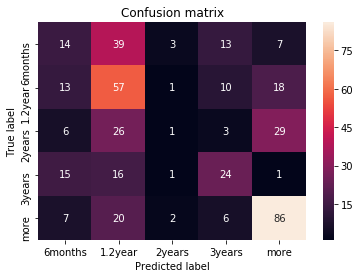

In [6]:
# Create logistic regression object
regr = linear_model.LogisticRegression()             
regr.fit(X_train_c, Y_train_c) 

Y_pred = regr.predict(X_test_c)
            
ICM_utils.plot_report(Y_test_c, Y_pred, labels)

# print ('Coefficients:', regr.coef_, regr.intercept_ )               
print("Mean square error (MSE): %.2f"
      % np.mean((Y_pred - Y_test_c) ** 2))      # The mean square error
print ('R^2: %.2f' % regr.score(X_test_c, Y_test_c) )  # Explained variance score

##  Benchmark Linear SVC

### Classification

In [7]:
classi = LinearSVC()
classi.fit(X_train_c, Y_train_c) 

Y_pred = classi.predict(X_test_r)

# print ('Coefficients:', regr.coef_, regr.intercept_ )               
print("Mean square error (MSE): %.2f"
      % np.mean((Y_pred - Y_test_r) ** 2))      # The mean square error

Mean square error (MSE): 3565726.83


             precision    recall  f1-score   support

    6months       0.00      0.00      0.00        76
    1.2year       0.30      0.87      0.44        99
     2years       0.00      0.00      0.00        65
     3years       0.00      0.00      0.00        57
       more       0.66      0.70      0.68       121

avg / total       0.26      0.41      0.30       418

Accuracy: 0.4090909090909091
Mean square error (MSE): 2.33


/Users/paul.pop/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


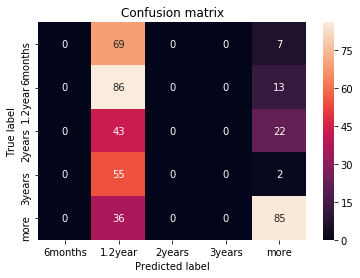

In [8]:
Y_pred = classi.predict(X_test_c)
            
ICM_utils.plot_report(Y_test_c, Y_pred, labels)

# print ('Coefficients:', regr.coef_, regr.intercept_ )               
print("Mean square error (MSE): %.2f"
      % np.mean((Y_pred - Y_test_c) ** 2))      # The mean square error

### Regression

In [9]:
regr = SVC(probability=True)

# N-am incredere in train test split si vreau sa il vad eu aici facut
X_t = np.array(df)
X_tr, X_te = train_test_split(X_t, train_size=0.8)

Y_tr = X_tr[:,3]
Y_te = X_te[:,3]
X_tr = np.delete(X_tr, [3, 6], axis=1)
X_te = np.delete(X_te, [3, 6], axis=1)

In [10]:
regr.fit(X_tr, Y_tr) 

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [11]:
Y_pred = regr.predict_proba(np.array(X_te))

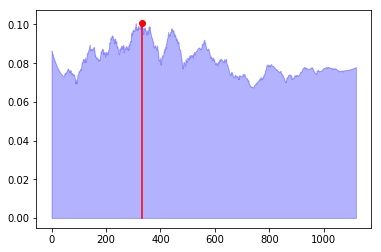

In [12]:
ICM_utils.plot_confidence_interval(predictions=Y_pred, 
                                   ground_truth=Y_te, 
                                   prediction_id=14,
                                   interval_in_days=91)

In [13]:
Y_pred = regr.predict(X_te)
            
# print ('Coefficients:', regr.coef_, regr.intercept_ )               
print("Mean square error (MSE): %.2f"
      % np.mean((Y_pred - Y_te) ** 2))      # The mean square error

Mean square error (MSE): 2151705.56


In [14]:
# Linear SVC

In [15]:
svc = LinearSVC(random_state=0)
svc.fit(X_train_r, Y_train_r)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=0, tol=0.0001,
     verbose=0)

In [16]:
Y_pred = svc.predict(X_test_r)
            
# print ('Coefficients:', regr.coef_, regr.intercept_ )               
print("Mean square error (MSE): %.2f"
      % np.mean((Y_pred - Y_test_r) ** 2))      # The mean square error
print ('R^2: %.2f' % regr.score(X_test_r, Y_test_r) )  # Explained variance score

Mean square error (MSE): 5519931.30
R^2: 0.07


# Classification

## Benchmark

In [17]:
# need the full dataset for cross validation
X = df.copy(deep=True)

Y = np.array(X['life_expectancy_bin'])
# remove columns
X.drop('life_expectancy', axis = 1, inplace=True)
X.drop('life_expectancy_bin', axis = 1, inplace=True)

X = np.array(X)

In [21]:
# define baseline model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(8, input_dim=54, activation='relu'))
    model.add(Dense(len(labels), activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [22]:
estimator = KerasClassifier(build_fn=baseline_model, epochs=100, batch_size=5, verbose=0)

In [23]:
results = cross_val_score(estimator, X, Y, cv=KFold(n=X.shape[0], n_folds=2, shuffle=True))
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Baseline: 42.57% (0.67%)


## Classification: Keras NN

In [24]:
seed = 7
np.random.seed(seed)

model = Sequential()
# model.add(Dense(108, input_shape=(54,), kernel_initializer='normal', activation='relu'))
# model.add(BatchNormalization())
# model.add(Dense(32, kernel_initializer='normal', activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(16, kernel_initializer='normal', activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(8, kernel_initializer='normal', activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(1, activation='sigmoid'))

model.add(Dense(64, activation='relu', input_dim=54))
model.add(Dropout(0.1))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(len(labels), activation='softmax'))

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

# model.add(Dense(input_dim=54, output_dim=12, activation='relu'))
# model.add(Dropout(0.1))
# model.add(Dense(input_dim=12, output_dim=12, activation='relu'))
# model.add(Dropout(0.1))
# model.add(Dense(output_dim=1, activation='softmax'))
# model.compile(loss='mean_squared_error', optimizer='adadelta', metrics=['accuracy'])

# 3
#tbCallBack = keras.callbacks.TensorBoard(log_dir='/tmp/keras_logs', write_graph=True)

# 4
#model.compile(loss='mean_squared_error', optimizer='adadelta', metrics=['accuracy'])

model.summary()

hist = model.fit(np.array(X_train_c), np.array(to_categorical(Y_train_c)), 
                 epochs=600, batch_size=128,  verbose=0, validation_split=0.3)#, callbacks=[tbCallBack])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 64)                3520      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 5)                 325       
Total params: 8,005
Trainable params: 8,005
Non-trainable params: 0
_________________________________________________________________


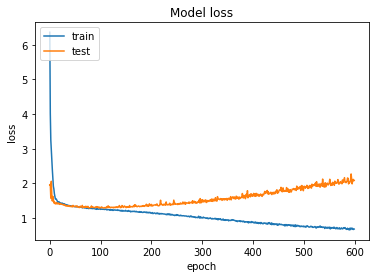

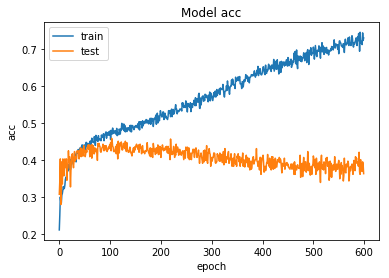

In [25]:
ICM_utils.plot_hist(hist)

In [26]:
hist = model.fit(np.array(X_train_c), np.array(to_categorical(Y_train_c)), 
                 epochs=120, batch_size=128,  verbose=0, validation_split=0.3)#, callbacks=[tbCallBack])

In [27]:
Y_pred = model.predict(np.array(X_test_c))

In [28]:
Y_pred = Y_pred.argmax(axis=-1)

             precision    recall  f1-score   support

    6months       0.19      0.29      0.23        76
    1.2year       0.33      0.34      0.34        99
     2years       0.22      0.18      0.20        65
     3years       0.33      0.35      0.34        57
       more       0.65      0.45      0.53       121

avg / total       0.38      0.34      0.35       418

Accuracy: 0.34210526315789475


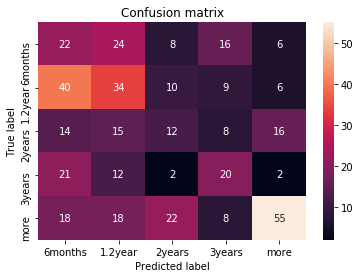

In [29]:
ICM_utils.plot_report(Y_test_c, Y_pred, labels)

## Classification: Ensamble of models

In [31]:
def mlp_model():
    model = Sequential()
    
    model.add(Dense(50, input_dim = 54, kernel_initializer='he_normal', activation='relu'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(50, kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))    
    model.add(Dropout(0.2))
    model.add(Dense(50, kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(50, kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(len(labels), kernel_initializer='he_normal'))
    model.add(Activation('softmax'))
    
    adam = optimizers.Adam(lr = 0.001)
    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    return model

In [32]:
mp = mlp_model()

In [33]:
hist = mp.fit(np.array(X_train_c), np.array(to_categorical(Y_train_c)), epochs=600, batch_size=128,  verbose=0, 
              validation_split=0.3)#, callbacks=[tbCallBack])

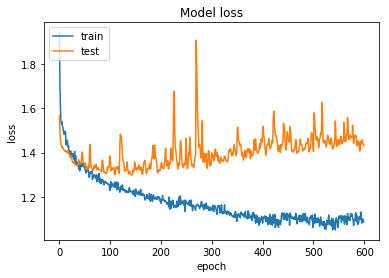

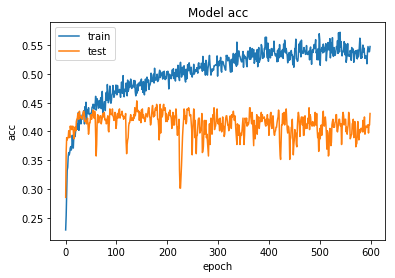

In [34]:
ICM_utils.plot_hist(hist)

In [36]:
# create 5 models to ensemble
model1 = KerasClassifier(build_fn = mlp_model, epochs = 150)
model2 = KerasClassifier(build_fn = mlp_model, epochs = 150)
model3 = KerasClassifier(build_fn = mlp_model, epochs = 150)
model4 = KerasClassifier(build_fn = mlp_model, epochs = 150)
model5 = KerasClassifier(build_fn = mlp_model, epochs = 150)

ensemble_clf = VotingClassifier(estimators = [('model1', model1), ('model2', model2), 
                                              ('model3', model3), ('model4', model4), 
                                              ('model5', model5)], voting = 'soft')

In [37]:
ensemble_clf.fit(np.array(X_train_c), np.array(Y_train_c))

Epoch 1/150
1668/1668 [==============================] - 2s 936us/step - loss: 1.7705 - acc: 0.2440
Epoch 2/150
1668/1668 [==============================] - 0s 134us/step - loss: 1.6012 - acc: 0.3285
Epoch 3/150
1668/1668 [==============================] - 0s 124us/step - loss: 1.5402 - acc: 0.3411
Epoch 4/150
1668/1668 [==============================] - 0s 123us/step - loss: 1.5149 - acc: 0.3807
Epoch 5/150
1668/1668 [==============================] - 0s 125us/step - loss: 1.5090 - acc: 0.3519
Epoch 6/150
1668/1668 [==============================] - 0s 125us/step - loss: 1.4710 - acc: 0.3687
Epoch 7/150
1668/1668 [==============================] - 0s 123us/step - loss: 1.4596 - acc: 0.3837
Epoch 8/150
1668/1668 [==============================] - 0s 127us/step - loss: 1.4577 - acc: 0.3819
Epoch 9/150
1668/1668 [==============================] - 0s 112us/step - loss: 1.4619 - acc: 0.3609
Epoch 10/150
1668/1668 [==============================] - 0s 102us/step - loss: 1.4409 - acc: 0.3765

1668/1668 [==============================] - 0s 113us/step - loss: 1.4105 - acc: 0.4041
Epoch 13/150
1668/1668 [==============================] - 0s 121us/step - loss: 1.3831 - acc: 0.4017
Epoch 14/150
1668/1668 [==============================] - 0s 121us/step - loss: 1.3759 - acc: 0.4161
Epoch 15/150
1668/1668 [==============================] - 0s 125us/step - loss: 1.3770 - acc: 0.3999
Epoch 16/150
1668/1668 [==============================] - 0s 121us/step - loss: 1.3779 - acc: 0.4077
Epoch 17/150
1668/1668 [==============================] - 0s 113us/step - loss: 1.3961 - acc: 0.3999
Epoch 18/150
1668/1668 [==============================] - 0s 112us/step - loss: 1.3630 - acc: 0.4149
Epoch 19/150
1668/1668 [==============================] - 0s 115us/step - loss: 1.3645 - acc: 0.4293
Epoch 20/150
1668/1668 [==============================] - 0s 119us/step - loss: 1.3482 - acc: 0.4281
Epoch 21/150
1668/1668 [==============================] - 0s 113us/step - loss: 1.3762 - acc: 0.4167
Epo

1668/1668 [==============================] - 0s 118us/step - loss: 1.3316 - acc: 0.4281
Epoch 24/150
1668/1668 [==============================] - 0s 120us/step - loss: 1.3579 - acc: 0.4149
Epoch 25/150
1668/1668 [==============================] - 0s 123us/step - loss: 1.3555 - acc: 0.4203
Epoch 26/150
1668/1668 [==============================] - 0s 130us/step - loss: 1.3583 - acc: 0.4281
Epoch 27/150
1668/1668 [==============================] - 0s 133us/step - loss: 1.3532 - acc: 0.4227
Epoch 28/150
1668/1668 [==============================] - 0s 130us/step - loss: 1.3536 - acc: 0.4311
Epoch 29/150
1668/1668 [==============================] - 0s 132us/step - loss: 1.3314 - acc: 0.4359
Epoch 30/150
1668/1668 [==============================] - 0s 130us/step - loss: 1.3284 - acc: 0.4365
Epoch 31/150
1668/1668 [==============================] - 0s 122us/step - loss: 1.3256 - acc: 0.4371
Epoch 32/150
1668/1668 [==============================] - 0s 109us/step - loss: 1.3216 - acc: 0.4371
Epo

1668/1668 [==============================] - 0s 118us/step - loss: 1.3012 - acc: 0.4466
Epoch 35/150
1668/1668 [==============================] - 0s 106us/step - loss: 1.2934 - acc: 0.4466
Epoch 36/150
1668/1668 [==============================] - 0s 115us/step - loss: 1.2796 - acc: 0.4610
Epoch 37/150
1668/1668 [==============================] - 0s 125us/step - loss: 1.3001 - acc: 0.4526
Epoch 38/150
1668/1668 [==============================] - 0s 133us/step - loss: 1.2972 - acc: 0.4466
Epoch 39/150
1668/1668 [==============================] - 0s 131us/step - loss: 1.3052 - acc: 0.4484
Epoch 40/150
1668/1668 [==============================] - 0s 130us/step - loss: 1.2844 - acc: 0.4664
Epoch 41/150
1668/1668 [==============================] - 0s 124us/step - loss: 1.2958 - acc: 0.4496
Epoch 42/150
1668/1668 [==============================] - 0s 109us/step - loss: 1.2930 - acc: 0.4490
Epoch 43/150
1668/1668 [==============================] - 0s 106us/step - loss: 1.2841 - acc: 0.4430
Epo

1668/1668 [==============================] - 0s 110us/step - loss: 1.2362 - acc: 0.4820
Epoch 116/150
1668/1668 [==============================] - 0s 115us/step - loss: 1.2388 - acc: 0.4892
Epoch 117/150
1668/1668 [==============================] - 0s 111us/step - loss: 1.2459 - acc: 0.4682
Epoch 118/150
1668/1668 [==============================] - 0s 107us/step - loss: 1.2462 - acc: 0.4694
Epoch 119/150
1668/1668 [==============================] - 0s 119us/step - loss: 1.2475 - acc: 0.4796
Epoch 120/150
1668/1668 [==============================] - 0s 118us/step - loss: 1.2338 - acc: 0.4946
Epoch 121/150
1668/1668 [==============================] - 0s 106us/step - loss: 1.2415 - acc: 0.4838
Epoch 122/150
1668/1668 [==============================] - 0s 108us/step - loss: 1.2275 - acc: 0.4796
Epoch 123/150
1668/1668 [==============================] - 0s 120us/step - loss: 1.2384 - acc: 0.4712
Epoch 124/150
1668/1668 [==============================] - 0s 111us/step - loss: 1.2355 - acc: 0

1668/1668 [==============================] - 0s 128us/step - loss: 1.3091 - acc: 0.4460
Epoch 47/150
1668/1668 [==============================] - 0s 117us/step - loss: 1.2921 - acc: 0.4496
Epoch 48/150
1668/1668 [==============================] - 0s 129us/step - loss: 1.2966 - acc: 0.4394
Epoch 49/150
1668/1668 [==============================] - 0s 114us/step - loss: 1.3069 - acc: 0.4454
Epoch 50/150
1668/1668 [==============================] - 0s 118us/step - loss: 1.3099 - acc: 0.4514
Epoch 51/150
1668/1668 [==============================] - 0s 121us/step - loss: 1.2923 - acc: 0.4365
Epoch 52/150
1668/1668 [==============================] - 0s 118us/step - loss: 1.3058 - acc: 0.4430
Epoch 53/150
1668/1668 [==============================] - 0s 119us/step - loss: 1.3002 - acc: 0.4323
Epoch 54/150
1668/1668 [==============================] - 0s 120us/step - loss: 1.2800 - acc: 0.4514
Epoch 55/150
1668/1668 [==============================] - 0s 124us/step - loss: 1.2885 - acc: 0.4604
Epo

Epoch 127/150
1668/1668 [==============================] - 0s 117us/step - loss: 1.2240 - acc: 0.4736
Epoch 128/150
1668/1668 [==============================] - 0s 114us/step - loss: 1.2326 - acc: 0.4688
Epoch 129/150
1668/1668 [==============================] - 0s 119us/step - loss: 1.2140 - acc: 0.4982
Epoch 130/150
1668/1668 [==============================] - 0s 113us/step - loss: 1.2252 - acc: 0.4730
Epoch 131/150
1668/1668 [==============================] - 0s 111us/step - loss: 1.2169 - acc: 0.4952
Epoch 132/150
1668/1668 [==============================] - 0s 118us/step - loss: 1.2183 - acc: 0.4802
Epoch 133/150
1668/1668 [==============================] - 0s 121us/step - loss: 1.2155 - acc: 0.4784
Epoch 134/150
1668/1668 [==============================] - 0s 118us/step - loss: 1.2251 - acc: 0.4694
Epoch 135/150
1668/1668 [==============================] - 0s 116us/step - loss: 1.2262 - acc: 0.4832
Epoch 136/150
1668/1668 [==============================] - 0s 117us/step - loss: 1

VotingClassifier(estimators=[('model1', <keras.wrappers.scikit_learn.KerasClassifier object at 0x12a3c2320>), ('model2', <keras.wrappers.scikit_learn.KerasClassifier object at 0x12a3c2518>), ('model3', <keras.wrappers.scikit_learn.KerasClassifier object at 0x12a3c26a0>), ('model4', <keras.wrappers.scikit_learn.KerasClassifier object at 0x12a3c2278>), ('model5', <keras.wrappers.scikit_learn.KerasClassifier object at 0x12a3c2390>)],
         n_jobs=1, voting='soft', weights=None)

In [38]:
Y_pred = ensemble_clf.predict(np.array(X_test_c))

/Users/paul.pop/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


/Users/paul.pop/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

    6months       0.26      0.12      0.16        76
    1.2year       0.34      0.71      0.46        99
     2years       0.00      0.00      0.00        65
     3years       0.43      0.42      0.42        57
       more       0.66      0.65      0.66       121

avg / total       0.38      0.44      0.39       418

Accuracy: 0.4354066985645933


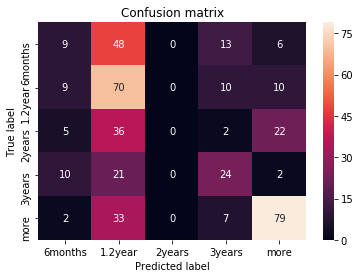

In [39]:
ICM_utils.plot_report(Y_test_c, Y_pred, labels)

# Regression

## Benchmark

In [40]:
def test_kfolds(regressor, x, y, kfolds = [5]):
    for k_folds in kfolds:
        # evaluate model with standardized dataset
        np.random.seed(182)
        estimators = []
        #estimators.append(('standardize', StandardScaler()))
        estimators.append(('mlp', regressor))
        pipeline = Pipeline(estimators)
        kfold = KFold(n=X.shape[0], n_folds=k_folds)
        results = cross_val_score(pipeline, x, y, cv=kfold)
        print("K_folds {}: \nMean {} \nStd {}".format(k_folds, results.mean(), results.std()))

In [41]:
# Need full dataset for cross validation
X = df.copy(deep=True)

Y = np.array(X['life_expectancy'])
# remove columns
X.drop('life_expectancy', axis = 1, inplace=True)
X.drop('life_expectancy_bin', axis = 1, inplace=True)

X = np.array(X)

In [42]:
# define base model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(13, input_dim=54, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=[metrics.MAPE,
                                                                        metrics.MSLE,
                                                                        metrics.MAE])
    return model

In [43]:
bm = baseline_model()
hist = bm.fit(np.array(X_train_r), np.array(Y_train_r), 
                 epochs=600, batch_size=128,  verbose=0, validation_split=0.3)

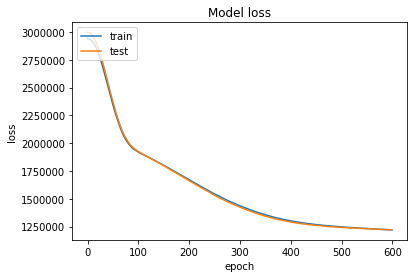

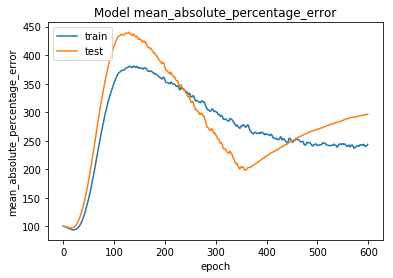

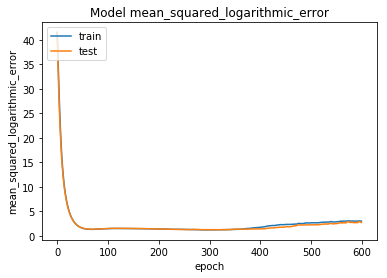

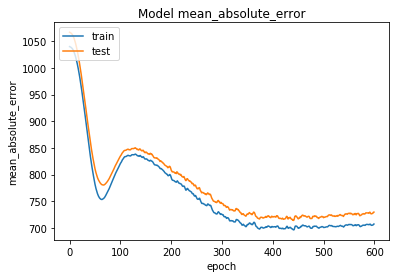

In [44]:
ICM_utils.plot_hist(hist)

In [45]:
test_kfolds(KerasRegressor(build_fn=baseline_model, nb_epoch=150, batch_size=128, verbose=0), X, Y)

K_folds 5: 
Mean -3074743.3380398555 
Std 2122300.58761617


In [46]:
bm.evaluate(np.array(X_test_r), np.array(Y_test_r))

418/418 [==============================] - 0s 34us/step


[1565975.0716208133, 245.3588148326965, 2.6407378016922034, 797.5153361781362]

## Regression: Keras NN

In [47]:
def larger_model():
    # create model
    model = Sequential()
    model.add(Dense(54, kernel_initializer="normal", input_dim=54, activation="relu"))
    model.add(Dense(27, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(15, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [48]:
test_kfolds(KerasRegressor(build_fn=larger_model, nb_epoch=150, batch_size=128, verbose=0), X, Y)

K_folds 5: 
Mean -3077959.0501562627 
Std 2124588.777193607


In [49]:
def wider_model():
    # create model
    model = Sequential()
    model.add(Dense(540, kernel_initializer="normal", input_dim=54, activation="relu"))
    model.add(Dense(270, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [50]:
test_kfolds(KerasRegressor(build_fn=wider_model, nb_epoch=150, batch_size=128, verbose=0), X, Y)

K_folds 5: 
Mean -2849443.3509008586 
Std 2004473.8977505653


# Pybrain

In [51]:
#!pip install git+https://github.com/pybrain/pybrain.git

## PyBrain: Regression

In [52]:
from pybrain.structure import SigmoidLayer, LinearLayer, TanhLayer, ReluLayer, SoftmaxLayer
from pybrain.datasets import SupervisedDataSet
from pybrain.supervised.trainers import BackpropTrainer
import pybrain.tools.shortcuts as pb
import numpy, math

# Build the dataset
xvalues = np.array(X_train_r)
yvalues = np.array(Y_train_r)
ds = SupervisedDataSet(54, 1)
for x, y in zip(xvalues, yvalues):
    ds.addSample((x), (y))
    
# Build the NN
nn1 = pb.buildNetwork(54,  # 1 input node
                   #108,    # number of nodes in 1st hidden layer
                   54,     # number of nodes in 4th hidden layer
                   1,     # 1 output node
                   bias = False,
                   hiddenclass = SigmoidLayer,
                   outclass = LinearLayer )

# Train the NN
trainer = BackpropTrainer(nn1, ds, learningrate = 0.01, weightdecay=0.01, momentum=0.02) #, verbose = True)
train_mse, validation_mse = trainer.trainUntilConvergence(maxEpochs = 20, continueEpochs=5, validationProportion=0.25)

##### Note on some of the parameters

**validationProportion**: ratio of the dataset that is used for the validation dataset.
If maxEpochs is given, at most that many epochs are trained. Each time validation error hits a minimum, try for continueEpochs # epochs to find a better one.

**Epoch**: one epoch means that every example has been seen once. It is preferable to track epochs rather than iterations since 
the number of iterations depends on the arbitrary setting of batch size. Batchs are used for example in the minibatch method,
for example, for 1000 examples, the NN is trained on examples 1-100, then examples 101-201, etc.

**Momentum**: 0 < m < 1 is a global parameter which must be determined by trial and error. Momentum simply adds a fraction m of the previous weight update to the current one. When the gradient keeps pointing in the same direction, this will increase the size of the steps taken towards the minimum. It is otherefore often necessary to reduce the global learning rate µ when using a lot of momentum (m close to 1). If you combine a high learning rate with a lot of momentum, you will rush past the minimum with huge steps! When the gradient keeps changing direction, momentum will smooth out the variations. Adding a momentum can help to speed up convergence to the minimum by damping oscillations.

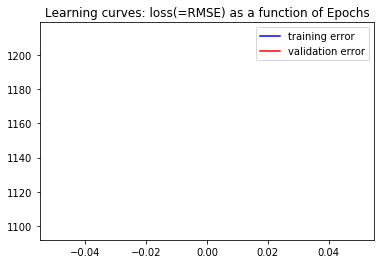

In [53]:
# Learning curves
plt.clf()
plt.plot(range(len(train_mse)), np.sqrt(train_mse), color='blue', label='training error')
plt.plot(range(len(validation_mse)), np.sqrt(validation_mse), color='red', label='validation error')
plt.title('Learning curves: loss(=RMSE) as a function of Epochs')
plt.legend()